# Pitch F/X 데이터를 활용한 분석
Pitch F/X 데이터는 `pfx.py`를 사용해 N사의 문자중계(gameday) 시스템에서 읽어올 수 있으며, `pbp_data`경로 아래에 연도/월별로 CSV 포맷으로 저장된다.

여기서는 `pfx.py`로 다운받은 데이터를 `pandas` 모듈을 사용하여 시각화하고 분석하는 예제를 제공한다.

`pandas`의 자세한 사용 방법을 기술하기에는 시간이 오래 걸리므로 생략한다.

분석에 필요한 함수는 `pfx_plot.py` 안에 미리 준비되어 있다.

## 1. 준비
필요한 모듈을 로드한다.

In [1]:
%matplotlib inline

# pandas 모듈은 흔히 pd라는 약칭으로 사용된다. Global 표준에 가깝다.
import pandas as pd
from IPython.display import HTML
from IPython.display import display

# 커스텀 라이브러리를 import한다.
from pfx_plot import *

# precision 세팅을 한다. 내부 값은 소수점 1자리까지만 표시되도록 저장하고, display 시에도 마찬가지로 표시하도록 한다.
pd.set_option('precision', 1)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

## 2. 데이터 읽어오기
PFX parser를 이용해 데이터는 CSV 포맷으로 저장되어 있다고 가정한다.

그렇지 않고 Linux/Mac을 사용하는 경우, 크롤러가 저장된 경로에서 아래 cell을 실행하면 2018년 3월 데이터를 새로 다운로드받고 파싱해서 저장한다.
- windows에서는 /dev/null이 없으므로 오류가 생길 수 있다.
 - 다만 cygwin Terminal이나 Git Bash shell 등에서 Jupyter Notebook을 실행 중이라면 괜찮을 것이다(/dev/null이 있을 것이므로).
- 현재 이 코드를 작성하는 시점이 2018년 3월이라서 3월 것을 다운로드받도록 했다.

In [2]:
!python pfx.py -d 2018 3 > /dev/null
!python pfx.py -c 2018 3 > /dev/null

2018년도 play-by-play 데이터를 pandas DataFrame으로 로드한다.

In [3]:
df = pd.read_csv('pbp_data/2018/2018.csv')
# Windows(한글)에서 저장한 데이터를 로드할 때는 아래 코드를 실행한다.
# df = pd.reac_csv('pbp_data/2018/2018.csv', encoding='cp949')

# show some
display(df[:5])

,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,balls,strikes,...,pos_7,pos_8,pos_9,game_date,home,away,stadium,referee,pa_number,pitch_number
0,직구,로저스,이용규,65742,74163,147,헛스윙,None,0,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,1
1,직구,로저스,이용규,65742,74163,147,스트라이크,None,0,1,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,2
2,슬라이더,로저스,이용규,65742,74163,135,스트라이크,삼진,0,2,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,3
3,직구,로저스,양성우,65742,62797,147,볼,None,0,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,2,1
4,직구,로저스,양성우,65742,62797,146,볼,None,1,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,2,2


로드된 데이터를 보면 열(column)이 길어서 중간에 축약 처리(`...`)가 된 것을 볼 수 있다.

열의 이름을 알기 위해 CSV 파일을 엑셀이나 텍스트 에디터로 열어보는 방법도 있지만, 1MB 이상 되는 파일을 매번 열어보는 건 시간상 현명한 선택이 아니다.

대신 pandas DataFrame에 내장된 기능을 사용, 로드한 데이터의 key를 알아낼 수 있다.

In [4]:
display(df.keys())

Index(['pitch_type', 'pitcher', 'batter', 'pitcher_ID', 'batter_ID', 'speed',
       'pitch_result', 'pa_result', 'balls', 'strikes', 'outs', 'inning',
       'inning_topbot', 'score_away', 'score_home', 'stands', 'throws',
       'on_1b', 'on_2b', 'on_3b', 'px', 'pz', 'pfx_x', 'pfx_z', 'x0', 'z0',
       'sz_top', 'sz_bot', 'pos_1', 'pos_2', 'pos_3', 'pos_4', 'pos_5',
       'pos_6', 'pos_7', 'pos_8', 'pos_9', 'game_date', 'home', 'away',
       'stadium', 'referee', 'pa_number', 'pitch_number'],
      dtype='object')

'key'는 CSV 파일의 열 이름을 뜻한다. 40여개 가까운 key가 있다. 매번 외울 수는 없으니 기억이 나지 않을 때마다 `df.keys()`를 잘 활용해주자.

## 3. 데이터 전처리

본격적인 분석을 하기에 앞서, 한가지 더 해야 할 것이 있다. 쓰레기값(Null)을 갖는 데이터 행(row)을 삭제하는 것이다.

예를 들어서 엑셀에서 CSV파일을 연 경우, 구속의 평균을 내야 하는데 숫자가 아닌 `NaN`(Not a Number; 숫자가 아님)이나 'None' 같은 문자 데이터가 들어있다면 Average 함수가 정상 작동하지 않을 것이다.

pandas도 마찬가지다. 웬만한 건 스마트하게 처리해주지만, 저런 필요 없는/에러를 유발할 수 있는 데이터는 삭제해줘야 한다.

In [5]:
# 쓰레기 값이 있는 데이터의 예시
display(df.loc[df.pitch_type.isnull()].loc[:, ['pitch_type', 'pitcher', 'batter', 'speed', 'px', 'pz']][:3])
display(df.loc[df.pitch_type == 'None'].loc[:, ['pitch_type', 'pitcher', 'batter', 'speed', 'px', 'pz']][:3])

,pitch_type,pitcher,batter,speed,px,pz
1432,NaN,윤성환,파레디스,0,-1.72259,2.83779
1433,NaN,윤성환,파레디스,0,0.28726,2.44873
2348,NaN,윤성빈,한동민,0,0.87464,1.6864


,pitch_type,pitcher,batter,speed,px,pz
514,None,헥터,로하스,None,None,None
674,None,왕웨이중,가르시아,None,None,None
675,None,왕웨이중,김현수,None,None,None


위 예시에서 보면 `pitch_type` 열에 `NaN`이나 'None' 같은 값이 있다. 철저히 배제해야 한다.

방법은 다음과 같다.

In [6]:
# NaN 처리; 숫자로 된 key는 대부분 쓰레기값이 섞여있다.
df.loc[:, 'speed'] = pd.to_numeric(df.speed, errors='coerce')
df.loc[:, 'px'] = pd.to_numeric(df.px, errors='coerce')
df.loc[:, 'pz'] = pd.to_numeric(df.pz, errors='coerce')
df.loc[:, 'pfx_x'] = pd.to_numeric(df.pfx_x, errors='coerce')
df.loc[:, 'pfx_z'] = pd.to_numeric(df.pfx_z, errors='coerce')
df.loc[:, 'x0'] = pd.to_numeric(df.x0, errors='coerce')
df.loc[:, 'z0'] = pd.to_numeric(df.z0, errors='coerce')

# pitch_type이 'NaN'인 row는 drop한다.
df = df.drop(df.loc[df.pitch_type.isnull()].index)

# pitch_type이 'None'인 row는 drop한다.
df = df.drop(df.loc[df.pitch_type == 'None'].index)

이렇게 제거했는데도 쓰레기 값이 섞여있을 수 있다. 확인해보자.

In [7]:
display(df.isnull().any().any())
print()
display(df.isnull().any())

True

pitch_type       False
pitcher          False
batter           False
pitcher_ID       False
batter_ID        False
speed            False
pitch_result     False
pa_result        False
balls            False
strikes          False
outs             False
inning           False
inning_topbot    False
score_away       False
score_home       False
stands           False
throws           False
on_1b            False
on_2b            False
on_3b            False
px               False
pz               False
pfx_x            False
pfx_z            False
x0               False
z0               False
sz_top           False
sz_bot           False
pos_1            False
pos_2            False
pos_3            False
pos_4            False
pos_5            False
pos_6            False
pos_7            False
pos_8            False
pos_9            False
game_date        False
home             False
away             False
stadium          False
referee           True
pa_number        False
pitch_numbe

실행 결과 referee 열에 쓰레기값이 섞여있는 게 확인된다. referee 데이터가 분석에 필요하다면 제거해주는 것이 좋다.

물론 데이터가 잘못 다운로드됐거나, 파싱이 잘못됐을 가능성도 있다.

여기서는 referee 관련 분석을 진행하지 않을 것이므로, 일단 넘어가도록 한다.

# 투수 데이터 분석

PBP 데이터에는 Pitch F/X 데이터가 들어있다. Pitch F/X 데이터는 투수 구속, 구종 이름, 무브먼트, 로케이션, 릴리즈 포인트 등을 포함한다.

이 데이터를 활용하는 예 중 하나는 '투수 레퍼토리 분석'이다. 예시로 켈리의 구종별 구속, break(무브먼트) 등을 알아보자.

In [8]:
# pitcher 이름이 '켈리'인 데이터만 읽어온다.
sub_df = df.loc[df.pitcher == '켈리']

print('켈리 데이터 개수 : {}개'.format(len(sub_df)))
display(sub_df[:3])

켈리 데이터 개수 : 102개


,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,balls,strikes,...,pos_7,pos_8,pos_9,game_date,home,away,stadium,referee,pa_number,pitch_number
894,직구,켈리,민병헌,65856,76249,148.0,스트라이크,None,0,0,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,1
895,직구,켈리,민병헌,65856,76249,147.0,볼,None,0,1,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,2
896,직구,켈리,민병헌,65856,76249,148.0,볼,None,1,1,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,3


데이터를 읽어왔지만 102구나 되는 내용을 일일이 들여다보기에는 시간이 부족하다.

구종 별로 묶어서 평균 구속, 최고 구속 등을 볼 수 있다면 시간이 절약될 것이다.

이럴 때 활용할 수 있는 게 `pandas DataFrame`의 `groupby` 함수다.

In [9]:
# pitch_type으로 묶어서 각 열 데이터의 평균(mean)을 구하고, 그 중 speed, pfx_x, pfx_z만 가져온다.
groupped = sub_df.groupby('pitch_type').mean().loc[:, ('speed', 'pfx_x', 'pfx_z')]

# 구종별 개수가 없으니 추가한다. count()는 모든 열에 동일한 값(해당 group의 개수)이 들어가므로, 그 중 한 열만 긁어오는 것이 핵심이다. speed가 아니어도 된다.
groupped['count'] = sub_df.groupby('pitch_type').count().speed

# 비슷하게 speed의 max, min 값도 추가한다.
groupped['max'] = sub_df.groupby('pitch_type').max().speed
groupped['min'] = sub_df.groupby('pitch_type').min().speed

# 확인해본다.
display(groupped)

,speed,pfx_x,pfx_z,count,max,min
pitch_type,,,,,,
슬라이더,135.0,2.8,2.5,7,136.0,133.0
직구,147.1,-5.5,9.4,32,150.0,144.0
체인지업,135.9,-8.4,7.2,16,140.0,131.0
커브,130.4,3.9,-2.8,23,136.0,125.0
커터,142.4,-5.0,7.9,12,146.0,138.0
투심,145.1,-7.7,8.7,12,149.0,137.0


원하던대로 구종별 구속, 브레이크 값 등을 정리했다. 포심(직구) 평균구속 147, 최고구속 150인 것을 보면 알려진 켈리의 데이터와 유사하다.

또한 앞서 pitch_type 열에서 `NaN`, 'None' 같은 값을 제거했기 때문에 이상한 그룹이 나오지 않는다.

제거하지 않았다면 슬라이더 위에 'None' 그룹이 표시되거나, 평균 계산이 제대로 되지 않았을 것이다.

# Plot 만들기(1) - 로케이션 찍어보기

### PBP 데이터를 활용해 방송사 중계화면처럼 로케이션을 찍어보자. 미리 준비된 함수를 활용한다.

`plot_calls()` 함수는 PBP 데이터의 px, pz 값을 2차원 x, y 값으로 사용해 포수 시점에서 본 공의 위치를 그림으로 그려낸다.

`px`, `pz` 값의 단위는 __피트__다(1피트 = 12인치 = 30.84cm).
- `pfx_x`, `pfx_z`의 단위는 __인치__(12인치 = 1피트)이며, `x0`, `z0`, `sz_top`, `sz_bot`의 단위는 __피트__다. 유의하자.

사용 예는 다음과 같다.

,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,balls,strikes,...,pos_7,pos_8,pos_9,game_date,home,away,stadium,referee,pa_number,pitch_number
2194,직구,김광현,이대호,77829,71564,152.0,헛스윙,None,0,0,...,정의윤,김강민,한동민,20180325,SK,LT,문학,NaN,4,1
2195,직구,김광현,이대호,77829,71564,150.0,볼,None,0,1,...,정의윤,김강민,한동민,20180325,SK,LT,문학,NaN,4,2
2196,직구,김광현,이대호,77829,71564,151.0,스트라이크,None,1,1,...,정의윤,김강민,한동민,20180325,SK,LT,문학,NaN,4,3
2197,직구,김광현,이대호,77829,71564,151.0,파울,None,1,2,...,정의윤,김강민,한동민,20180325,SK,LT,문학,NaN,4,4
2198,슬라이더,김광현,이대호,77829,71564,144.0,헛스윙,삼진,1,2,...,정의윤,김강민,한동민,20180325,SK,LT,문학,NaN,4,5


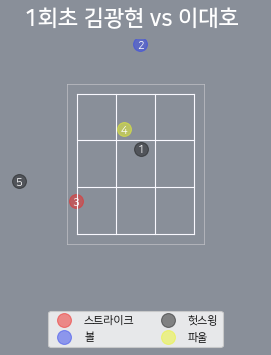

In [10]:
# 간단하게 한 타석만 살펴보기로 한다.
sub_df = df.loc[(df.pitcher == '김광현') & (df.batter == '이대호') & (df.inning == 1)]

# 데이터를 확인
display(sub_df)

# 플롯을 띄운다.
plot_calls(sub_df, title='1회초 김광현 vs 이대호', calls=['스트라이크', '볼', '헛스윙', '파울'], legends=True, show_pitch_number=True)

나름 괜찮게(?) 로케이션이 표시된다. 단 그림의 범위 밖에 들어간 공은 표시되지 않는다.

함수에 들어간 인자(argument)들의 의미는 각각 다음과 같다.

`plot_calls( dataframe, title=None, calls=None, legends=True, show_pitch_number=True, print_std=False)`
- `title` : 플롯 맨 위에 표시될 문자열.
  - 기본은 `None`으로 아무것도 표시하지 않는다.
- `calls` : 표시하고 싶은 투구 결과(pitch_result). 리스트 혹은 문자열 값만 받을 수 있다. 여러 값을 주는 경우 리스트를, 한 값만 주는 경우 문자열 하나만 사용한다.
  - 기본 값은 `None`이며, 모든 투구 결과를 표시한다.
- `legends` : 투구 결과(pitch result) 라벨 표시 여부를 결정한다. True면 그림 아래에 투구 결과 종류를 표시하고 False면 표시하지 않는다.
  - 기본값은 True다.
- `show_pitch_number` : 타석에 따른 투구 순서(초구, 2구, ...) 표시 여부를 결정한다. True면 로케이션 위에 투구수를 표시하고 False면 표시하지 않는다.
  - 기본값은 True다.

### 스트라이크 존 규격

위에서 설명하지 않은 `print_std`라는 인자가 있다. 이것을 True로 하면 그림의 스트라이크 존 모양을 타자 각각에 맞춰 정규화한 그림을 표시한다.
- 예를 들어서 정근우, 호세 알투베 같은 단신 타자는 스트라이크 존의 상하 경계가 더 좁다. 이런 것에 맞춰 보정한 그림을 표시하는 것이다.

`print_std`의 기본값은 False다. 즉 사용자가 설정하지 않으면 타자가 바뀌어도 동일한 존이 표시된다.

기본적으로 표시되는 존의 규격은 다음과 같다.
- 존의 __아래쪽 경계__는 지면에서 __+1.579 피트__, __위쪽 경계__는 __+3.325 피트__를 사용한다. N사 중계의 값을 그대로 사용했다.
  - 그림에서 표시되는 존 모양의 안쪽 경계선(짙은 흰색 선)으로 표시된다.
- 존의 __좌우 경계 너비__는 __홈 베이스의 좌우 폭__과 같다(17인치 = __17/12피트__). 가운데를 0으로 해 __-17/24 피트__, __+17/24 피트__가 홈의 좌우 경계선이 된다.
- __바깥쪽 경계(옅은 흰색 선)__는 위 경계선에서 __공 반개씩__ 더한 것이다. 공 1개 지름은 약 3인치(3/12 피트)이기 때문에 __1/8 피트__를 상하좌우로 더해 그린 것이다.

# Plot 만들기(2) - 경기 전체 판정 / 결과 살펴보기

### 경기 전체의 스트라이크 존 판정이 어땠는지 살펴보자.

특정 경기에서 판정이 어땠는지, 어떤 공이 파울이 됐고 어떤 공이 헛스윙이 됐는지 살펴보자.

미리 준비된 함수 `plot_match_calls`를 사용하면 된다. 인자는 `DataFrame` 외에 `title` 만 존재한다.
- 너무 많은 데이터를 인자로 넘기면 수행 시간이 오래 걸릴 수 있다. 항상 조심하자.

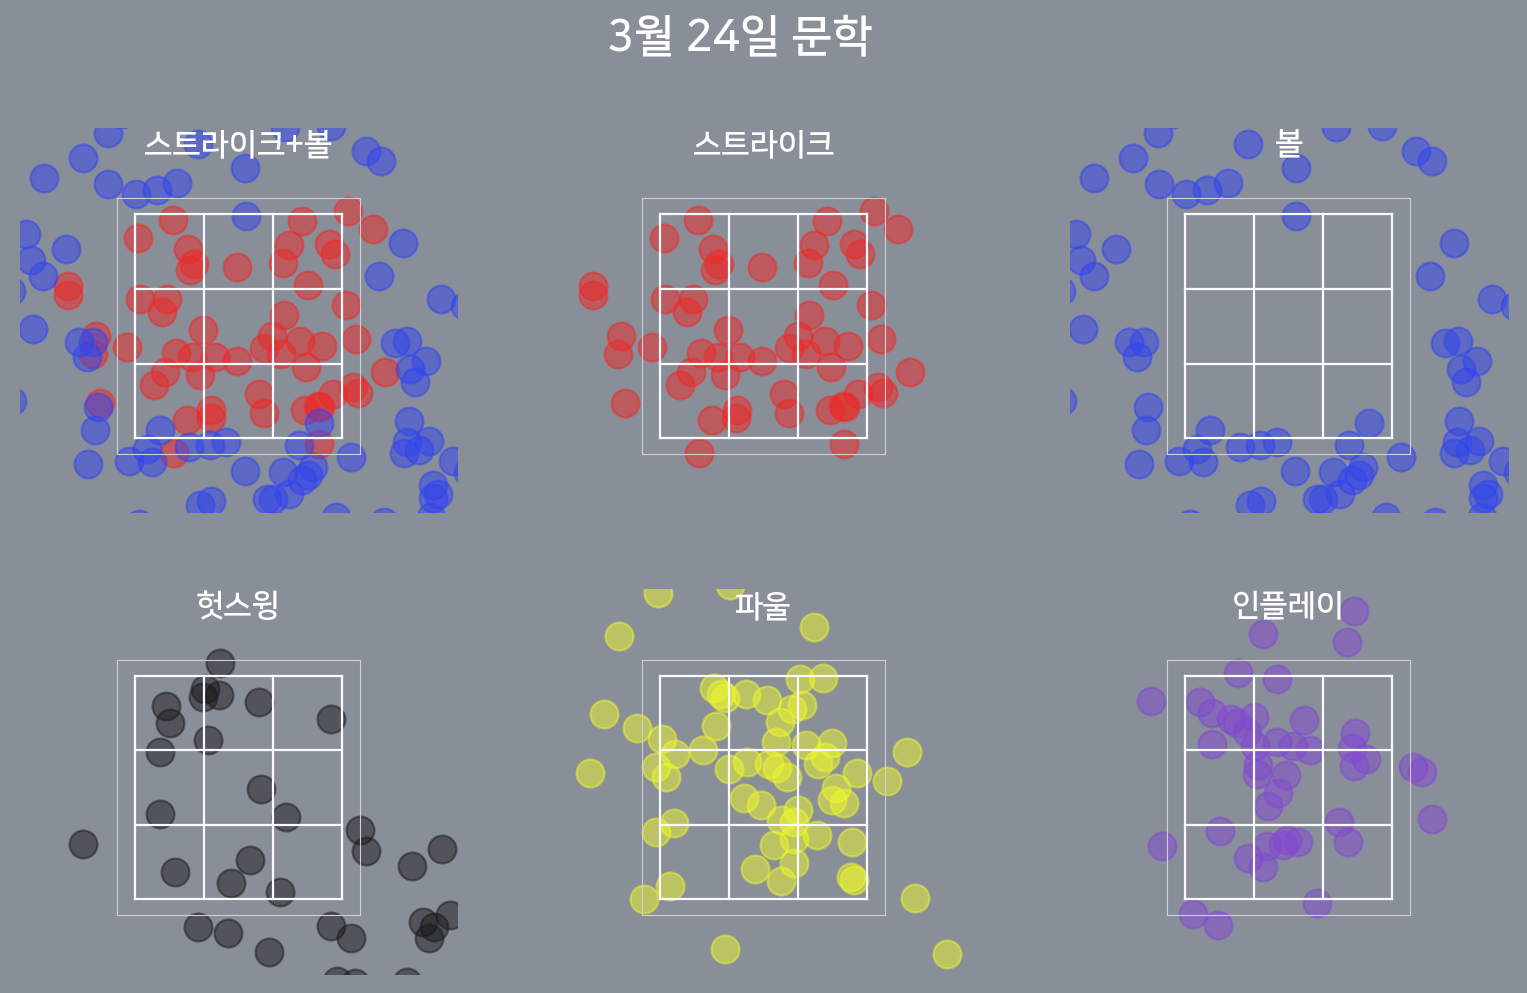

In [11]:
# 3월 24일 문학 경기를 준비한다.
sub_df = df.loc[(df.stadium == '문학') & (df.game_date == 20180324)]

# 경기 전체 결과를 표시한다.
plot_match_calls(sub_df, title='3월 24일 문학')

# 릴리즈 포인트 살펴보기

PBP 데이터에서 릴리즈 포인트는 `x0`, `z0` 값을 활용해 살펴볼 수 있다.

릴리즈 포인트 분석은 투수의 컨디션을 파악하는데 도움이 된다. 이번에는 준비된 함수 대신 직접 데이터를 다뤄보자.

일단 투구 구종이 어떤 것이 있는지 알아보자. `DataFrame`의 `drop_duplicates` 함수를 쓰면 중복된 값을 제거하여 데이터의 종류를 알아볼 수 있다.

In [12]:
pitch_types = df.pitch_type.drop_duplicates()

display(pitch_types)

0        직구
2      슬라이더
16       커브
21       투심
62     체인지업
188      포크
329      커터
350     너클볼
Name: pitch_type, dtype: object

종류가 많은데 일단 너클볼을 제외한 구종들에 색을 대응시켜본다.

- 구종 분류는 Pitch F/X 시스템에서 알고리즘을 활용해 미리 분류한 것이다. 실제 투수가 의도한 것과 결과가 다를 수 있다.

In [13]:
# 구종 별로 색을 미리 준비해놓는다.
Colors = {
    '직구': '#3245ef',
    '슬라이더': '#ef2926',
    '체인지업':'#1a1b1c',
    '커브':'#edf72c',
    '포크':'#8348d1',
    '투심':'#edf72c',
    '커터':'#1a1b1c'
}

모든 투구의 릴리즈 포인트를 표시하는 건 별 의미가 없다. 특정 투수의 릴리즈 포인트만 분석하는 것이 좋다.

김광현의 데이터를 살펴보도록 하겠다.

In [14]:
sub_df = df.loc[df.pitcher == '김광현']

본격적으로 Plot을 그려보자. 지금까지 그린 Plot은 모두 `matplotlib`이라는 라이브러리, 그 중에서도 `pyplot`이라는 모듈을 사용해 그린 것이다.

이 모듈을 import한다.

In [15]:
import matplotlib.pyplot as plt

이제 그림을 그릴 캔버스를 준비한다.

In [16]:
# figsize는 플롯을 그릴 캔버스의 크기, dpi는 'dot per inch'의 약자로 해상도를 결정한다.
# facecolor는 캔버스 배경을 흰색으로 칠하겠다는 것이다. 기본은 투명인데, 투명한 바탕에 그린 그림은 환경에 따라 배경이 까맣게 나타날 수도 있다.
fig = plt.figure(figsize=(4, 4), dpi=80, facecolor='white')

캔버스 위에 준비한 데이터의 `x0`, `z0` 좌표를 점으로 뿌리면 성공이다.

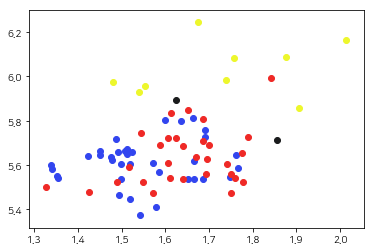

In [17]:
for p in pitch_types:
    # 구종을 던진 기록이 없으면 넘어간다.
    if len(sub_df.loc[sub_df.pitch_type == p]) == 0:
        continue
    
    # 구종 별로 색깔(color)과 라벨(label)을 맞춰서 점을 찍는다(scatter).
    plt.scatter(sub_df.loc[sub_df.pitch_type == p].x0, sub_df.loc[sub_df.pitch_type == p].z0, color=Colors[p], label=p)

다 좋은데 너무 그림이 확대되어 있는 것 같다. 이때는 축의 범위를 원하는대로 설정할 수 있다.

보기 좋게 표시하려면 릴리즈포인트의 범위를 고려해주면 좋다.

- 왼손 투수의 경우, 릴리즈포인트의 X좌표(`x0`)는 보통 1~3피트 범위에 존재한다.
- 높이를 나타내는 Z좌표(`z0`)는 보통 손 방향에 관계 없이 5~7피트 범위에 존재한다.

메이저리그의 투구 트래킹 자료를 제공하는 [Brooks Baseball](http://www.brooksbaseball.net) 사이트는 오른손 투수를 표시하는 경우도 고려해서 X축의 범위는 -3~3피트, Z축 범위는 0~10피트를 설정하고 있다.

이 범위에 맞춰 축의 범위를 조정해보자.

- Jupyter Notebook에서 플롯을 그릴 때는 Cell 단위로 플롯 데이터가 리셋되기 때문에, 바로 윗 cell의 코드를 다시 붙여줘야 데이터가 제대로 표시된다.

[-3, 3, 0, 10]

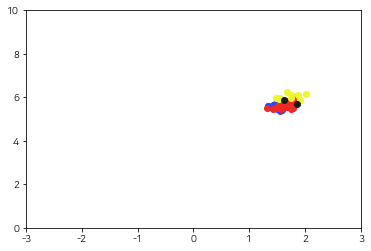

In [18]:
for p in pitch_types:
    # 구종을 던진 기록이 없으면 넘어간다.
    if len(sub_df.loc[sub_df.pitch_type == p]) == 0:
        continue
    
    # 구종 별로 색깔(color)과 라벨(label)을 맞춰서 점을 찍는다(scatter).
    plt.scatter(sub_df.loc[sub_df.pitch_type == p].x0, sub_df.loc[sub_df.pitch_type == p].z0, color=Colors[p], label=p)

# X축과 Y축 최소/최대 좌표 순서로 지정한다.
plt.axis([-3, 3, 0, 10])

이번엔 범위를 너무 키워서 점이 잘 보이지 않는다. 범위를 다시 조정해보자.

여기에 구종 라벨을 표시하기 위해 범례(legend)도 추가하고, 최종적으로 플롯을 띄워보자.

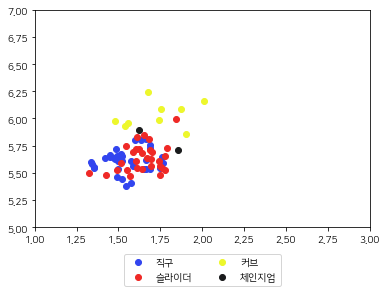

In [19]:
for p in pitch_types:
    # 구종을 던진 기록이 없으면 넘어간다.
    if len(sub_df.loc[sub_df.pitch_type == p]) == 0:
        continue
    
    # 구종 별로 색깔(color)과 라벨(label)을 맞춰서 점을 찍는다(scatter).
    plt.scatter(sub_df.loc[sub_df.pitch_type == p].x0, sub_df.loc[sub_df.pitch_type == p].z0, color=Colors[p], label=p)

# X축과 Y축 최소/최대 좌표 순서로 지정한다.
plt.axis([1, 3, 5, 7])

# 범례(legend)의 location은 숫자로 지정할 수 있다. 여기서는 9를 사용. 그 밖의 인자(argument)에 대한 자세한 내용은 matplotlib의 레퍼런스 페이지를 참조.
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

# 헛스윙 비율 분석하기

마지막으로 2017년 자료를 활용해 구종 별로 헛스윙 유도를 가장 잘한 투수들을 찾아보자.

투구수가 너무 적은 경우 기록이 왜곡될 수 있기 때문에 구종 하나당 최소 250구 이상 던진 투수들을 분석 대상으로 한다.

In [20]:
# 2017년 데이터가 준비되지 않은 경우 아래 코드를 주석 제거하고 실행한다.
#!python pfx.py -d 2017 > /dev/null
#!python pfx.py -c 2017 > /dev/null

df = pd.read_csv('pbp_data/2017/2017.csv')

# string으로 된 숫자를 float, int등 numeric으로 바꾼다.
df.loc[:, 'px'] = pd.to_numeric(df.px, errors='coerce')
df.loc[:, 'pz'] = pd.to_numeric(df.pz, errors='coerce')
df.loc[:, 'pfx_x'] = pd.to_numeric(df.pfx_x, errors='coerce')
df.loc[:, 'pfx_z'] = pd.to_numeric(df.pfx_z, errors='coerce')
df.loc[:, 'sz_top'] = pd.to_numeric(df.sz_top, errors='coerce')
df.loc[:, 'sz_bot'] = pd.to_numeric(df.sz_bot, errors='coerce')

분석 순서는 다음과 같다.

- (1) 전체 데이터에서 투수 명단을 추출한다.
- (2) 전체 데이터에서 구종 명단을 추출한다.
- (3) 투수-구종으로 데이터를 묶는다(group by).
- (4) 헛스윙 횟수를 잰다(count).
- (5) 구종별로 투구수에서 헛스윙이 차지하는 비율을 계산한다.

(4), (5)에서 구종별 비율을 계산하기 위해서는 `pitch_type`이 `NaN`, 'None' 등으로 표시된 데이터를 제거해야 한다.

또한 (4)에서 헛스윙에는 '번트헛스윙'도 포함된다. (5)까지 진행한 뒤 '번트헛스윙' 비율과 '헛스윙' 비율을 더하면 되겠지만, 모든 투수/구종에 대해 같은 일을 반복하기는 귀찮으니 `pitch_result` 중 '번트헛스윙'을 '헛스윙'으로 바꿔보도록 하자. `pandas DataFrame`의 `replace`함수를 사용하면 편하다.

In [21]:
# NaN과 None을 pitch_type에서 제거한다.
df = df.drop(df.loc[(df.pitch_type.isnull()) | (df.pitch_type == 'None')].index)

# pitch_result의 번트헛스윙을 헛스윙으로 바꾼다. 기왕 하는 김에 번트파울도 파울로 바꾼다.
df.pitch_result = df.pitch_result.replace('번트헛스윙', '헛스윙')
df.pitch_result = df.pitch_result.replace('번트파울', '파울')

다음으로는 헛스윙 비율을 계산한다.

구종 별로 다음 과정을 반복한다.
- (1) 최소 투구수가 넘는 투수만 찾아내고
- (2) 투수-투구 결과(pitch_result; 헛스윙/타격/파울 등)로 그룹을 묶는다.
- (3) 그룹 별로 개수를 구한다.
- (4) 투수 그룹 안에서 투구 결과의 퍼센티지를 구한다.

코드가 조금 복잡하지만 다음과 같다.

In [22]:
# swstr% 구하기; swstr% = 헛스윙/전체 pitch (구종별)
sub_df = pd.DataFrame({'pitcher': df.pitcher, 'pitch_type': df.pitch_type, 'pitch_result': df.pitch_result, 'swstr%': 1})

# 구종 종류
pitch_types = df.pitch_type.drop_duplicates()

# 최소 투구수; 구종별 250구로 설정한다.
pitch_threshold = 250

for pitch in pitch_types:
    # 해당 구종만 분류; 투수 그룹으로 묶음
    pitchers = sub_df.loc[sub_df.pitch_type == pitch].groupby(['pitcher'])
    
    # 최소 투구수 넘는 경우만 필터
    filtered = pitchers.filter(lambda x: x['swstr%'].sum() > pitch_threshold)
    
    # 필터 통과한 투수 목록
    l = filtered.pitcher.drop_duplicates()
    
    # 특정 구종은 투수가 없는 경우도 있음 - 이런 경우는 패스
    if len(l) == 0:
        print(pitch + ' pass')
        continue
        
    # 구종 필터 걸고, 투수-투구결과(헛스윙/타격/파울 등)로 그룹
    swstrs = sub_df.loc[ (sub_df.pitcher.isin(list(l))) &
                         (sub_df.pitch_type == pitch) ].groupby(['pitcher', 'pitch_result']).agg({'swstr%': 'sum'})

    # pitch result별 swstr%를 구종 투구수 전체로 나눔; 이렇게하면 swstr%가 퍼센티지로 나옴.
    swstr_pcts = swstrs.groupby(level=0).apply(lambda x: 100*x/x.sum())
    
    # 헛스윙 raw num 컬럼도 하나 표시.
    swstr_pcts['raw_num'] = swstrs['swstr%']
    
    print(pitch)
    result = swstr_pcts.iloc[swstr_pcts.index.get_level_values('pitch_result') == '헛스윙'].sort_values('swstr%', ascending=False)

    display(result[:3])

직구


,,swstr%,raw_num
pitcher,pitch_result,,
정우람,헛스윙,15.3,97
신재웅,헛스윙,12.5,42
임창용,헛스윙,12.3,58


슬라이더


,,swstr%,raw_num
pitcher,pitch_result,,
심창민,헛스윙,22.9,59
장시환,헛스윙,22.7,58
윤길현,헛스윙,19.8,52


커브


,,swstr%,raw_num
pitcher,pitch_result,,
해커,헛스윙,20.0,51
배장호,헛스윙,15.0,69
헥터,헛스윙,13.5,49


체인지업


,,swstr%,raw_num
pitcher,pitch_result,,
고영표,헛스윙,25.1,172
함덕주,헛스윙,21.1,123
켈리,헛스윙,20.2,125


투심


,,swstr%,raw_num
pitcher,pitch_result,,
박희수,헛스윙,12.1,31
켈리,헛스윙,11.4,38
원종현,헛스윙,10.8,28


포크


,,swstr%,raw_num
pitcher,pitch_result,,
김진성,헛스윙,26.4,155
이민호,헛스윙,23.0,80
최충연,헛스윙,22.3,65


싱커 pass
커터


,,swstr%,raw_num
pitcher,pitch_result,,
손승락,헛스윙,14.3,67
켈리,헛스윙,14.1,74
허프,헛스윙,9.3,53


너클볼


,,swstr%,raw_num
pitcher,pitch_result,,
피어밴드,헛스윙,11.6,49
